# Filterentwurfsmethoden
 
Demonstriere verschiedene Filterentwurfsmethoden und vergleiche die Ergebnisse

In [6]:
import numpy as np
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange,
                    linspace, array, zeros, ones)
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import scipy.signal as sig

import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, title, clf, xlim, ylim)

import sys
sys.path.append('..')
import dsp_fpga_lib as dsp

In der nächsten Zelle werden die Filterspezifikationen gewählt

In [7]:
f_S = 400 # Samplingfrequenz
f_DB = 40 # Grenzfreq. Durchlassband (DB)
f_SB = 50 # Grenzfrequenz Sperrband (SB)
F_DB = f_DB/(f_S/2) # Frequenzen bezogen
F_SB = f_SB/(f_S/2) # auf HALBE Abtastfreq.
#
A_DB = 0.1 # max. Ripple im DB in dB
A_DB_lin = (10**(A_DB/20.0)-1) / \
  (10**(A_DB/20.0)+1)*2 # und linear
A_SB = 60 # min. Dämpfung im SB in dB
A_SB_lin = 10**(-A_SB/20.0) # und linear
#
L = 44 # Manuelle Vorgabe Filterordnung

Jetzt können Sie ein Filterentwurfverfahren aktivieren:

In [8]:
############## FIR-Filterentwurf ##########
a = [1] # Nennerpolynom = 1 bei FIR-Filtern
#=== Windowed FIR / Least Square =========
F_c  = f_DB / (f_S/2)  # -6dB - Frequenz
b = sig.firwin(L, F_c) # Hamming-Window
#=== Frequency Sampling ==================
b = sig.firwin2(L, [0, F_DB, F_SB, 1],
           [1, 1, 0, 0])
#=== REMEZ / Parks-McClellan / Equiripple
W_DB = 1;  W_SB = 1 # manuelle Ordnung:
b = sig.remez(L, [0, F_DB, F_SB, 1],
            [0, 1], [W_DB, W_SB], Hz = 2)
# minimale Ordnung:
(L_min,F,A,W) = dsp.remezord([F_DB, F_SB],
    [1, 0], [A_DB_lin, A_SB_lin], Hz = 2)
b = sig.remez(L_min, F, A, W )

In [9]:
##############  IIR-Filterentwurf  ########
#=== Butterworth Filter===================
[Lb,F_b] = sig.buttord(F_DB,F_SB,A_DB,A_SB)
#[b, a] = sig.butter(Lb, F_b)
#=== IIR-Wrapper (nur Python) =====
#[b, a] = sig.iirdesign(F_DB, F_SB,
#              A_DB, A_SB, ftype='ellip')
############################################
print('Filterkoeffizienten:')
print('a = ', a); print('b = ', b)

Filterkoeffizienten:
a =  [1]
b =  [-5.49763008e-04 -3.60953595e-05  4.12504010e-04  1.09454932e-03
  1.77191538e-03  2.12020779e-03  1.86944985e-03  9.61710290e-04
 -3.58726117e-04 -1.58957933e-03 -2.16159438e-03 -1.70971010e-03
 -2.99181994e-04  1.52195702e-03  2.90639716e-03  3.07871420e-03
  1.73932880e-03 -6.99832961e-04 -3.20008141e-03 -4.51556673e-03
 -3.78964057e-03 -1.05233435e-03  2.64981116e-03  5.61557586e-03
  6.24210322e-03  3.84812196e-03 -8.40162385e-04 -5.83524934e-03
 -8.68387730e-03 -7.63020514e-03 -2.59422595e-03  4.52522868e-03
  1.04936841e-02  1.21418851e-02  7.95148091e-03 -9.31255533e-04
 -1.08355989e-02 -1.69678513e-02 -1.55858231e-02 -6.01596209e-03
  8.47816159e-03  2.15693492e-02  2.63495682e-02  1.85296166e-02
 -9.84893788e-04 -2.53814841e-02 -4.36741506e-02 -4.44787514e-02
 -2.05170650e-02  2.79005229e-02  9.19022885e-02  1.56194407e-01
  2.03717931e-01  2.21220658e-01  2.03717931e-01  1.56194407e-01
  9.19022885e-02  2.79005229e-02 -2.05170650e-02 -4.447

Im Folgenden werden die Filterentwürfe in der Frequenzebene dargestellt

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


Text(0.5, 1.0, 'Group Delay $ \\tau_g$')

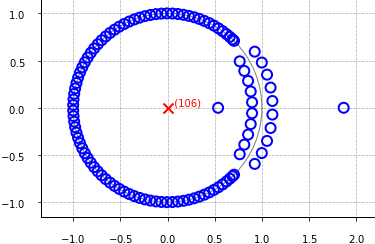

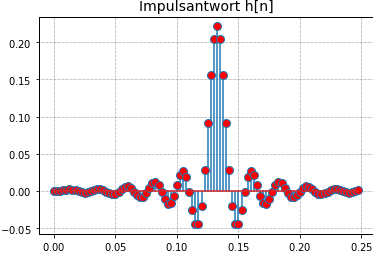

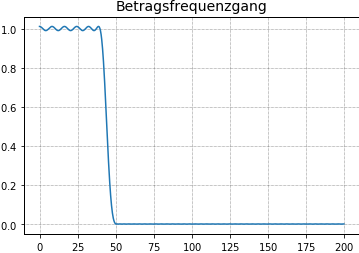

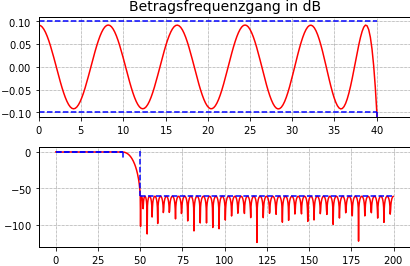

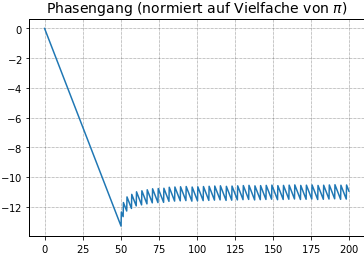

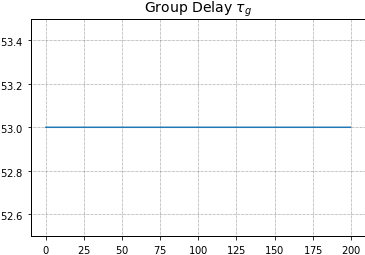

In [12]:
## Calculate H(w), w = 0 ... pi, 1024 Pts.
[w, H] = sig.freqz(b, a, 1024)
# Translate w to physical frequencies:
f = w / (2 * pi) * f_S
############## Plot the Results #########
## Pol/Nullstellenplan
fig1, ax1 = plt.subplots(1)
[z, p, k] = dsp.zplane(b, a, plt_ax = ax1)
## ----- Impulsantwort -----
fig2, ax2 = plt.subplots(1); ax2.grid(True)
[h, td] = dsp.impz(b, a, f_S)  #Impulsantwort / Koeffizienten
[ml, sl, bl] = ax2.stem(td, h)
plt.setp(ml, 'markerfacecolor', 'r', 'markersize', 8)
ax2.set_title(r'Impulsantwort h[n]')
## ----- Linear frequency plot -----
fig3, ax3 = plt.subplots(1); ax3.grid(True)
ax3.plot(f, abs(H))
ax3.set_title(r'Betragsfrequenzgang')
## Log. Frequenzgang mit Spezifikationen
fig4, (ax41,ax42) = plt.subplots(2,1)
ax41.plot(f,20 * log10(abs(H)), 'r'); ax41.grid(True)
ax41.plot([0, f_DB],[-A_DB, -A_DB],'b--') # untere Spec-Grenze
ax41.plot([f_DB, f_DB], [ -A_DB, -A_DB-10], 'b--') #@ F_DB
if len(a) == 1:
    ax41.plot([0, f_DB],[A_DB, A_DB], 'b--') # obere Spec-Grenze
    ax41.axis([0, f_DB * 1.1, -A_DB*1.1, A_DB * 1.1])
else:
    ax41.plot([0, f_DB], [0, 0], 'b--') # obere Spec-Grenze
    ax41.axis([0, f_DB * 1.1, -A_DB * 1.1, A_DB * 0.1])
ax41.set_title(r'Betragsfrequenzgang in dB')
#

ax42.plot(f,20 * log10(abs(H)), 'r'); ax42.grid(True)
ax42.plot([0,  f_DB],[-A_DB, -A_DB],'b--') # untere Grenze DB
if len(a) == 1:
    ax42.plot([0,  f_DB], [A_DB, A_DB],'b--') # obere Grenze DB
else:
    ax42.plot([0, f_DB], [0, 0], 'b--') # obere Grenze DB
ax42.plot([f_SB, f_S/2.], [-A_SB, -A_SB], 'b--') # obere Grenze SB
ax42.plot([f_DB, f_DB], [-A_DB, -A_DB-10], 'b--') # @ F_DB
ax42.plot([f_SB, f_SB],[1, -A_SB],'b--') # @ F_SB
fig4.set_tight_layout(True) # pad=1.2, h_pad=None, w_pad=None
#=========================================
## Phasengang
fig5, ax5 = plt.subplots(1); ax5.grid(True)
ax5.plot(f,np.unwrap(np.angle(H))/pi)
# Ohne unwrap wird Phase auf +/- pi umgebrochen
ax5.set_title(r'Phasengang (normiert auf Vielfache von $\pi$)')
## Groupdelay
fig6, ax6 = plt.subplots(1); ax6.grid(True)
[tau_g, w] = dsp.grpdelay(b, a, Fs = f_S)
ax6.plot(w, tau_g); ax6.grid(True)
ax6.set_ylim(max(min(tau_g)-0.5,0), (max(tau_g) + 0.5))
ax6.set_title(r'Group Delay $ \tau_g$') # (r: raw string)

### Experimente und Fragen

- Experimentieren Sie mit unterschiedlichen Filterentwürfen

***
### Copyright

(c) 2016 - 2018 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources), feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2018*.